In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers, losses, preprocessing, regularizers
import tensorflow_hub as hub
import tensorflow_text

import xgboost as xgb
import catboost as cb

# Check if GPU is available

In [2]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [3]:
df_train = pd.read_csv('../../Data/nlp-getting-started/train.csv')
df_test  = pd.read_csv('../../Data/nlp-getting-started/test.csv')

df_all = pd.concat([df_train, df_test])

print(f'df_train.shape = {df_train.shape}')
print(f'df_test.shape  = {df_test.shape}')
print(f'df_all.shape   = {df_all.shape}')

df_train.shape = (7613, 5)
df_test.shape  = (3263, 4)
df_all.shape   = (10876, 5)


In [4]:
df_train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


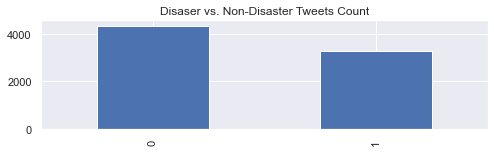

In [5]:
_ = df_train['target'].value_counts().sort_index().plot.bar(figsize=(8,2), title='Disaser vs. Non-Disaster Tweets Count')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train['keyword'].dropna().head()

31    ablaze
32    ablaze
33    ablaze
34    ablaze
35    ablaze
Name: keyword, dtype: object

In [8]:
df_train['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
body%20bags              41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
df_train['location'].dropna().head()

31                       Birmingham
32    Est. September 2012 - Bristol
33                           AFRICA
34                 Philadelphia, PA
35                       London, UK
Name: location, dtype: object

In [10]:
df_train['location'].value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
The Sun's Corona                1
Island Lake, IL                 1
Cheshire. London. #allover      1
The Web                         1
 Blood Indian Reserve           1
Name: location, Length: 3341, dtype: int64

# Train-Test Split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train.text.values, df_train.target.values,
    stratify=df_train.target.values,
    random_state=42,
    test_size=0.1,
    shuffle=True
)

print(f'X_train.shape = {X_train.shape} | y_train.shape = {y_train.shape}')
print(f'X_val.shape   = {X_val.shape}  | y_val.shape   = {y_val.shape}')

X_train.shape = (6851,) | y_train.shape = (6851,)
X_val.shape   = (762,)  | y_val.shape   = (762,)


# Building Basic Models

### Logistic Regression on TF-IDF

In [12]:
tfv = TfidfVectorizer(
    min_df=3,
    max_features=None,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,3),
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    stop_words='english'
)

tfv.fit(list(X_train) + list(X_val))

X_train_tfv = tfv.transform(X_train)
X_val_tfv   = tfv.transform(X_val)

print(f'X_train_tfv.shape = {X_train_tfv.shape} | y_train.shape = {y_train.shape}')
print(f'X_val_tfv.shape   = {X_val_tfv.shape}  | y_val.shape   = {y_val.shape}')

X_train_tfv.shape = (6851, 9229) | y_train.shape = (6851,)
X_val_tfv.shape   = (762, 9229)  | y_val.shape   = (762,)


In [13]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.75712
Precision = 0.83704
Recall    = 0.69113


### Logistic Regression on CountVectorizer

In [14]:
ctv = CountVectorizer(
    analyzer='word',
    token_pattern='\w{1,}',
    ngram_range=(1,3),
    stop_words='english',
)

ctv.fit(list(X_train) + list(X_val))

X_train_ctv = ctv.transform(X_train)
X_val_ctv   = ctv.transform(X_val)

print(f'X_train_ctv.shape = {X_train_ctv.shape} | y_train.shape = {y_train.shape}')
print(f'X_val_ctv.shape   = {X_val_ctv.shape}  | y_val.shape   = {y_val.shape}')

X_train_ctv.shape = (6851, 132070) | y_train.shape = (6851,)
X_val_ctv.shape   = (762, 132070)  | y_val.shape   = (762,)


In [15]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train_ctv, y_train)

predictions = clf.predict(X_val_ctv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.73737
Precision = 0.82022
Recall    = 0.66972


### Naive Bayes on TF-IDF

In [16]:
clf = MultinomialNB()
clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.72125
Precision = 0.83806
Recall    = 0.63303


### XGBoost on TF-IDF

In [17]:
clf = xgb.XGBClassifier(
    max_depth=7, 
    n_estimators=200, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=10, 
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
)

clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.73058
Precision = 0.79496
Recall    = 0.67584


### XGBoost on CountVectorizer

In [18]:
clf = xgb.XGBClassifier(
    max_depth=7, 
    n_estimators=200, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=10, 
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
)

clf.fit(X_train_ctv, y_train)

predictions = clf.predict(X_val_ctv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.74622
Precision = 0.82836
Recall    = 0.6789


# Deep Learning

In [19]:
tf.random.set_seed(42)

In [20]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

### Using nnlm-en-dim50/1 embedding

In [21]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [22]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=5,
    verbose=0
)

In [23]:
model.evaluate(X_val, y_val)

24/24 [==============================] - 0s 2ms/step - loss: 0.4773 - accuracy: 0.7703


[0.4773203432559967, 0.7703412175178528]

<AxesSubplot:>

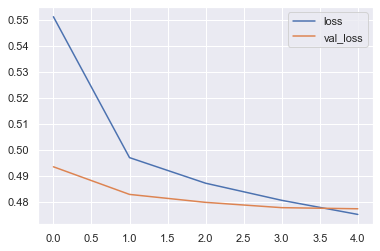

In [24]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

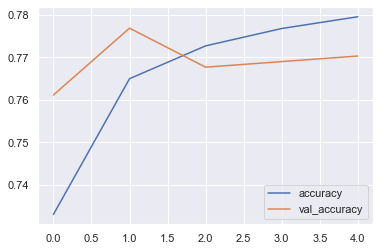

In [25]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [26]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

24/24 [==============================] - 0s 2ms/step
F1 Score  = 0.71074
Precision = 0.77338
Recall    = 0.65749


### Using universal-sentence-encoder-multilingual embedding

In [27]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3",
                   dtype=tf.string, input_shape=[], output_shape=[]),    
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [28]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=2,
    verbose=1
)

Epoch 1/2
215/215 [==============================] - 7s 18ms/step - loss: 0.4970 - accuracy: 0.7844 - val_loss: 0.4181 - val_accuracy: 0.8097
Epoch 2/2
215/215 [==============================] - 3s 15ms/step - loss: 0.4188 - accuracy: 0.8145 - val_loss: 0.4070 - val_accuracy: 0.8373


In [29]:
model.evaluate(X_val, y_val)

24/24 [==============================] - 0s 13ms/step - loss: 0.4070 - accuracy: 0.8373


[0.4070351719856262, 0.8372703194618225]

<AxesSubplot:>

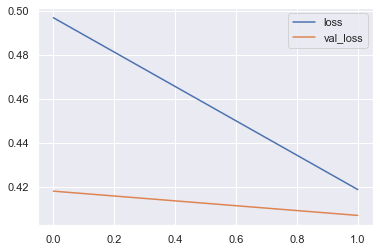

In [30]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

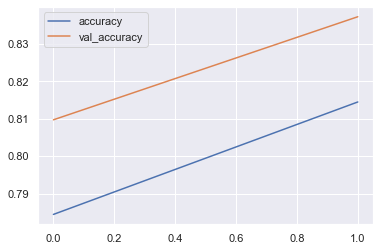

In [31]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [32]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

24/24 [==============================] - 1s 13ms/step
F1 Score  = 0.8
Precision = 0.84642
Recall    = 0.75841


In [33]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 12ms/step


#### Leaderboard Score

<img src="score_univ_sen_encoder.png">

### Using universal-sentence-encoder-multilingual embedding + LSTM

In [34]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3",
                   dtype=tf.string, input_shape=[], output_shape=[]),    
    layers.Reshape((-1,512)),
    layers.LSTM(4),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [35]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=8,
    verbose=1
)

Epoch 1/8
215/215 [==============================] - 10s 21ms/step - loss: 0.6306 - accuracy: 0.6922 - val_loss: 0.5330 - val_accuracy: 0.8031
Epoch 2/8
215/215 [==============================] - 4s 17ms/step - loss: 0.4830 - accuracy: 0.8059 - val_loss: 0.4442 - val_accuracy: 0.8123
Epoch 3/8
215/215 [==============================] - 4s 16ms/step - loss: 0.4382 - accuracy: 0.8123 - val_loss: 0.4256 - val_accuracy: 0.8163
Epoch 4/8
215/215 [==============================] - 3s 15ms/step - loss: 0.4228 - accuracy: 0.8158 - val_loss: 0.4167 - val_accuracy: 0.8228
Epoch 5/8
215/215 [==============================] - 3s 15ms/step - loss: 0.4143 - accuracy: 0.8170 - val_loss: 0.4109 - val_accuracy: 0.8241
Epoch 6/8
215/215 [==============================] - 3s 15ms/step - loss: 0.4093 - accuracy: 0.8218 - val_loss: 0.4117 - val_accuracy: 0.8202
Epoch 7/8
215/215 [==============================] - 3s 16ms/step - loss: 0.4044 - accuracy: 0.8227 - val_loss: 0.4068 - val_accuracy: 0.8215
Epoch

In [36]:
model.evaluate(X_val, y_val)

24/24 [==============================] - 0s 11ms/step - loss: 0.4075 - accuracy: 0.8215


[0.4074939787387848, 0.8215222954750061]

<AxesSubplot:>

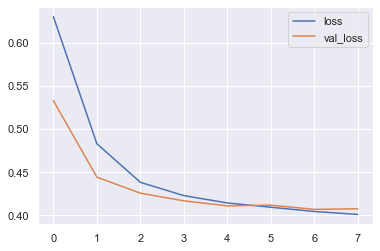

In [37]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

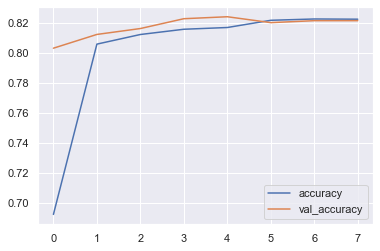

In [38]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [39]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

24/24 [==============================] - 1s 11ms/step
F1 Score  = 0.78481
Precision = 0.81311
Recall    = 0.75841


In [40]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 12ms/step


## Using pre-trained BERT

In [41]:
early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [42]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer(    
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False
)

outputs = encoder(encoder_inputs)

pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

embedding_model = tf.keras.Model(text_input, pooled_output)

model = keras.Sequential([
    embedding_model,
    layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5)),
    layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5)),
    layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5)),
#     layers.Dense(64, activation="relu"),
#     layers.Dense(32, activation="relu"),
#     layers.Dense(8, activation="relu"),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [43]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping_monitor]
)

Epoch 1/25
429/429 [==============================] - 32s 61ms/step - loss: 0.6231 - accuracy: 0.6732 - val_loss: 0.5618 - val_accuracy: 0.7507
Epoch 2/25
429/429 [==============================] - 25s 59ms/step - loss: 0.5620 - accuracy: 0.7270 - val_loss: 0.5272 - val_accuracy: 0.7520
Epoch 3/25
429/429 [==============================] - 25s 59ms/step - loss: 0.5451 - accuracy: 0.7357 - val_loss: 0.5414 - val_accuracy: 0.7323
Epoch 4/25
429/429 [==============================] - 26s 60ms/step - loss: 0.5208 - accuracy: 0.7538 - val_loss: 0.4854 - val_accuracy: 0.7822
Epoch 5/25
429/429 [==============================] - 25s 59ms/step - loss: 0.5126 - accuracy: 0.7529 - val_loss: 0.5190 - val_accuracy: 0.7612
Epoch 6/25
429/429 [==============================] - 25s 59ms/step - loss: 0.5234 - accuracy: 0.7519 - val_loss: 0.4987 - val_accuracy: 0.7546
Epoch 7/25
429/429 [==============================] - 25s 59ms/step - loss: 0.5037 - accuracy: 0.7625 - val_loss: 0.4966 - val_accuracy:

In [44]:
model.evaluate(X_val, y_val)

24/24 [==============================] - 3s 106ms/step - loss: 0.4713 - accuracy: 0.7717


[0.4712636172771454, 0.7716535329818726]

<AxesSubplot:>

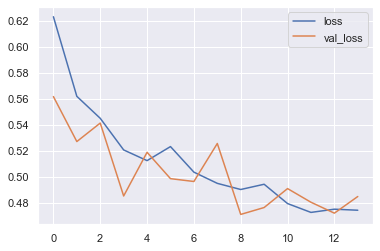

In [45]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

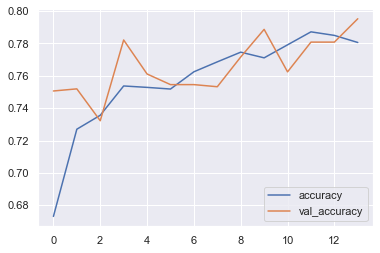

In [46]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [47]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

24/24 [==============================] - 3s 104ms/step
F1 Score  = 0.68478
Precision = 0.84
Recall    = 0.57798


In [48]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 11s 105ms/step


# Bidirectional LSTM with trained Embedding and Masking

In [49]:
max_tokens = 20000
max_length = 600

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(df_train.text.values)

In [50]:
text_vectorization("This layer transforms sentences to sequences of integer numbers").shape

TensorShape([600])

In [51]:
model = models.Sequential(
    [
        text_vectorization,
        layers.Embedding(input_dim=max_tokens, output_dim=512, mask_zero=True),
#         layers.Bidirectional(layers.LSTM(4, return_sequences=True)),
#         layers.Bidirectional(layers.LSTM(16, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(4)),        
#         layers.Dropout(0.5),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 600)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 600, 512)          10240000  
                                                                 
 bidirectional (Bidirectiona  (None, 8)                16544     
 l)                                                              
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 10,256,585
Trainable params: 10,256,585


In [52]:
callbacks = [
    keras.callbacks.ModelCheckpoint("bidirectional_lstm.tf", save_best_only=True, save_format='tf')
]

history = model.fit(
    X_train, y_train, 
#     df_train.text.values, df_train.target.values,
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
214/215 [============================>.] - ETA: 0s - loss: 0.5333 - accuracy: 0.7544

INFO:tensorflow:Assets written to: bidirectional_lstm.tf\assets


INFO:tensorflow:Assets written to: bidirectional_lstm.tf\assets


215/215 [==============================] - 22s 83ms/step - loss: 0.5332 - accuracy: 0.7545 - val_loss: 0.4495 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3312 - accuracy: 0.8698 - val_loss: 0.4792 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2365 - accuracy: 0.9134 - val_loss: 0.5017 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1666 - accuracy: 0.9406 - val_loss: 0.5514 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1169 - accuracy: 0.9588 - val_loss: 0.6393 - val_accuracy: 0.7402


<AxesSubplot:>

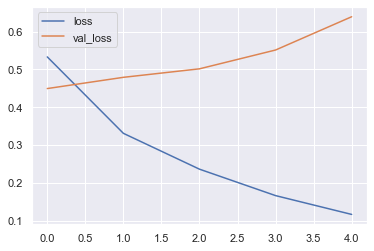

In [53]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

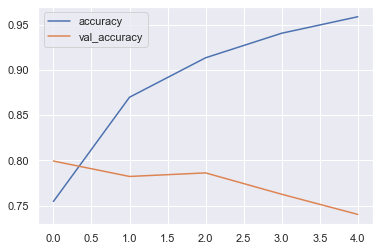

In [54]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [55]:
model = models.load_model("bidirectional_lstm.tf")

model.evaluate(X_val, y_val)

24/24 [==============================] - 2s 18ms/step - loss: 0.4482 - accuracy: 0.7979


[0.4482041299343109, 0.7979002594947815]

In [56]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

24/24 [==============================] - 2s 6ms/step
F1 Score  = 0.75122
Precision = 0.80208
Recall    = 0.70642


In [57]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 6ms/step
